# Visualisierung mit Python: pygal und seaborn

Beim Prozessieren und Analysieren von Texten entstehen oft eine Menge Daten, die man visualisieren möchte, um sie zu explorieren oder um Ergebnisse anschaulich zu machen. 

Dafür gibt es eine Menge Libraries in Python. Im Notebook Pandas 3 haben wir bereits direkt aus pandas heraus einige Informationen aus einem DataFrame mit der Methode `.plot()` visualisiert. Für etwas anspruchsvollere Visualisierungen bietet es sich aber an, andere Libraries einzusetzen.  

Die Standard-Library ist `matplotlib`, auf die auch `pandas` zurückgreift. Sie ist sehr umfangreich und erlaubt eine Kontrolle aller Visualisierungsdetails. Hier soll es aber um zwei andere Libraries gehen: `pygal` (das sich u.a. durch seinen SVG-basierten Output und seine Interaktivität auszeichnet) und `seaborn` (das sich u.a. durch ästhetisch besonders ansprechende Visualisierungsmöglichkeiten auszeichnet). 

* Pygal: https://www.pygal.org/en/stable/
* Seaborn: https://seaborn.pydata.org/

Ziel der Sitzung ist es, Ihnen zwei Bibliotheken einmal zu zeigen und Ihnen die ersten Schritte mit diesen Bibliotheken zu erleichtern. Beide sind recht umfangreich, sodass wir nur an der Oberfläche kratzen können. Aber es macht auch Spaß, weitere Möglichkeiten auszuprobieren.

## Importe

In [16]:
import pandas as pd
from os.path import join
import os

## Erster Datensatz: Satzlängen

Wir verwenden als Beispiel relativ einfache Daten mit nur wenigen Dimensionen. Es handelt sich dabei um Informationen zur durchschnittlichen Satzlänge von Romanen in verschiedenen Korpora aus der European Literary Text Collection. Zu jedem Roman liegen einerseits Metadaten vor (Identifier, Autor, Publikationsjahr), außerdem der Wert für die durchschnittliche Satzlänge. Der Beispieldatensatz mit den deutschen Romanen enthält Informationen zu rund 100 Romanen in der Zeit 1840 bis 1920. 

Eine Übersicht über die im englischen Korpus enthaltenen Romane findet man hier: https://distantreading.github.io/ELTeC/eng/index.html

Die Metadaten- und Ergebnis-Tabelle liegt im Ordner `data` und hat den Namen `eltec-deu_avgsentlens.csv`. 

Mehr zu dieser Daten: https://dragonfly.hypotheses.org/1152

In [17]:
lendata_file = join("..", "data", "eltec-eng_avgsentlens.csv")

def read_csv(data_file):
    with open(data_file, "r", encoding="utf8") as infile: 
        data = pd.read_csv(infile, sep=";", index_col=0)
    print(data.head())
    return data


lendata = read_csv(lendata_file)

               author  year  avgsentlen
ENG18531        Yonge  1853   22.967280
ENG18980  BaringGould  1898   17.972027
ENG19181         West  1918   22.428850
ENG18872        Lyall  1887   22.688276
ENG19091         Ward  1909   17.640123


## Visualisierung mit pygal

Die beiden wesentlichen Dimensionen des Datensatzes sind Jahr und mittlere Satzlänge für jeden Roman, für deren Visualisierung sich ein Scatterplot anbietet. 

Mit pygal lassen sich sehr leicht 2D-Scatterplots erstellen, bei denen ein paar Metadaten mit in die SVG-Datei integriert werden und dann interaktiv abgerufen werden können. Wir nutzen hierfür den Plot-Typ "XY" von pygal. 

Dokumentation: https://www.pygal.org/en/stable/documentation/types/xy.html  

### Minimalversion in zwei Varianten

Zunächst mal eine "minimal viable visualization". 

Dabei gibt es mehrere Schritte: 

1. Wir legen den Plot mit dem richtigen Plot-Typ erst einmal an.
1. Wir definieren die Datenpunkte, die in dem Plot dargestellt werden sollen
1. Wir fügen diese Datenpunkte dem Plot hinzu
1. Wir speichern den Plot in einer Datei ab. 

Die Datei mit der Bildatei wird im aktuellen Arbeitsordner abgespeichert und lässt sich bspw. mit einem Browser öffnen. 

In [18]:
import pygal

def plot_using_pygal1a(data): 
    scatterplot = pygal.XY(stroke=False)
    points = list(zip(data["year"], data["avgsentlen"])) # 2 Spalten im DF => 1 Liste von Tuples.
    scatterplot.add("Sentence Length", points)
    scatterplot.render_to_file("eltec-eng_scatterplot1a.svg")

plot_using_pygal1a(lendata)

Das ist in dieser Form zwar sehr einfach zu schreiben, aber vielleicht doch noch nicht ganz ideal. 

Als alternativer Ansatz können wir auch jeden Punkt einzeln anlegen. Hierfür verwenden wir einen `for`-Loop über dem DataFrame. Für jede Zeile wird ein eigener Eintrag angelegt: Wir müssen also für jeden Punkt (= jeden Roman) aus dem Datensatz ein Label, einen Wert für die X-Achse und einen Wert für die Y-Achse herausziehen. 

Dann fügen wir noch innerhalb des Loops dem Plot jeweils einen neuen Eintrag hinzu. 

In [19]:
import pygal

def plot_using_pygal1b(data): 
    scatterplot = pygal.XY()
    for row in data.iterrows(): 
        label = row[0]  # ID
        point = [(row[1]["year"], row[1]["avgsentlen"])]  # Tuple: (year, avgsentlen)
        scatterplot.add(label, point)
    scatterplot.render_to_file("eltec-eng_scatterplot1b.svg")

plot_using_pygal1b(lendata)

### Leichte Erweiterungen

Das funktioniert, ist aber visuell und funktional noch nicht wirklich ansprechend. Wir möchten eine Reihe von Ergänzungen vornehmen: 

1. Titel und Achsenbeschriftung
1. Selbst definiertes Farbschema
1. Keine Legende (zu viele Items)
1. Gerundete Werte
1. Vereinfachte Labels
1. Auch vertikale Guides


In [20]:
from pygal.style import Style
import re

def plot_using_pygal2(data): 
    data = data.round({'avgsentlen': 2}) # (4)
    mystyle = Style(
        colors=('#2D882D', '#88CC88', '#55AA55', '#116611', '#004400')) # (2)
    scatterplot = pygal.XY(show_legend = False, # (3)
                           human_readable = True,
                           style = mystyle,
                           show_x_guides=True) # (6)
    scatterplot.title = "Average sentence length per novel in ELTEC-eng" # (1)
    scatterplot.x_title = "Year of publication" # (1)
    scatterplot.y_title = "Average sentence length" # (1)
    for row in data.iterrows(): 
        point = [(row[1]["year"], row[1]["avgsentlen"])] # Tuple X,Y
        label = str(row[1][0]) + " (" + str(row[0]) + ")" # author (ID) # Titel fehlt
        scatterplot.add(label, point)
    scatterplot.render_to_file("ELTeC-eng_scatterplot2.svg")

plot_using_pygal2(lendata)

## Visualisierungen mit seaborn

Pygal hat eine Reihe von Vorteilen: sehr einfaches und logisches Interface, SVG-Ausgabe, interaktive Elemente, gute Dokumentation. Und es gibt durchaus eine Menge an Plot-Typen, die zur Verfügung stehen (siehe Dokumentation). Aber die Möglichkeiten zur individuellen Anpassung der Plots sind doch begrenzt und die ästhetische Anmutung ist eingeschränkt. 

Das können andere Libraries besser. Ein Beispiel dafür ist `seaborn`, das insbesondere bei Density Plots und Heatmaps schöne Angebote macht und es erlaubt, ansprechende Colormaps einzubinden. Daher nun noch einige Anwendungsbeispiele mit seaborn. 

### Scatterplot mit Regressionslinie

Zunächst einmal legen wir erneut einen Scatterplot an, diesmal eben mit seaborn. (Im Hintergrund nutzt seaborn auch matplotlib bzw. einen Teil davon, pyplot, deswegen importieren wir das auch und können darüber bestimmte Aspekte des Plots steuern.)

Schön ist, dass seaborn es auch sehr einfach erlaubt, eine Regressionslinie einzuziehen, ohne dass man selbst die Werte dafür separat berechnen muss. Das geht mit dem Plot-Typ "regplot". 

Einige Eigenschaften und Parameter: 

1. Wir können direkt in den DataFrame indizieren
1. Die Ordnung des Polynoms für die Regressionslinie kann angegeben werden 
1. Farbwerte für die Punkte, die Linie und den Konfidenzintervall 
1. Range der Achsen (ylim, ylim)
1. Hilfslinien (grid)

Der resultierende Plot ist m.E. sowohl informativer (durch die Regressionslinie) als auch ästhetisch ansprechender als der Pygal-Plot, es fehlt aber die Möglichkeit, detaillierte Informationen zu einzelnen Punkten zu bekommen. 


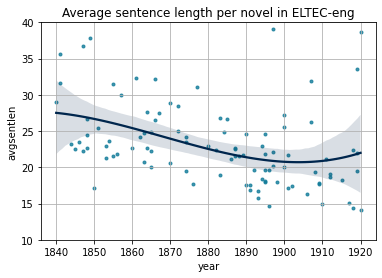

In [29]:
from matplotlib import pyplot as plt
import seaborn as sns

def scatterplot_seaborn(data): 
    regplot = sns.regplot(data=data, 
                          x="year",
                          y="avgsentlen", 
                          marker=".", 
                          order=3, 
                          color="#117b99", 
                          scatter_kws={"color": "#117b99"}, 
                          line_kws={"color": "#00264D"}
                          ).set_title("Average sentence length per novel in ELTEC-eng")
    fig = regplot.get_figure()
    plt.ylim(10, 40)
    plt.grid()
    fig.savefig("ELTeC-eng_scatterplot3.png", dpi=600)

scatterplot_seaborn(lendata)

### Heatmaps

Eine Stärke von seaborn sind auch die Heatmaps. Siehe: https://seaborn.pydata.org/generated/seaborn.heatmap.html

Heatmaps sind vor allem dann geeignet, wenn man einen zweidimensionalen Datensatz hat, in dem für verschiedene Gegenstände ein Reihe von ähnlichen Informationen vorliegen, bspw.: 

* für verschiedene europäische Städte, die Sonnenscheindauer in Abhängigkeit des Monats. 
* in verschiedenen Ländern, die Dauer der täglichen Handynutzung für verschiedene Altersgruppen
* oder eben, wie in unserem Beispiel: für die Pressemitteilungen verschiedener Universitäten in Hong Kong die Wahrscheinlichkeit verschiedener Topics 

Die Gemeinsamkeit dieser Datensätze ist, dass wir immer zwei Dimensionen haben, die den Datensatz strukturieren, wobei alle Werte untereinander gut vergleichbar und bspw. in der gleichen Größenordnung liegen. (Ist das nicht der Fall, weil es sich um unterschiedliche Informationen handelt, kann eine Normalisierung der Werte hilfreich sein.) 


### Datensatz

Topics in Pressemitteilungen von Universitäten in Hong Kong, 2003-2016. 

Wir werfen erst einmal einen Blick in diesen Datensatz. Er enthält für jedes Dokument die Angabe der Universität und das Publikationsjahr der Pressemitteilung sowie die Topic-Wahrscheinlichkeiten für 50 verschiedene Topics, die hier jeweils durch ihre 3 wichtigsten Wörter zusammengefasst werden. 

In [47]:
topicdatafile = join("..", "data", "topics-hong-kong.tsv")

def read_csv(datafile): 
    with open(datafile, "r", encoding="utf8") as infile: 
        data = pd.read_csv(infile, sep="\t", index_col="idno")
    print(data.iloc[0:5, 0:5])
    return data

topicdata = read_csv(topicdatafile)

        univ  year  public_support_research  lecture_community_science  \
idno                                                                     
cu0001  CUHK  2010                 0.735449                   0.000000   
cu0006  CUHK  2010                 0.000000                   0.000000   
cu0009  CUHK  2010                 0.000000                   0.000000   
cu0013  CUHK  2010                 0.000000                   0.042757   
cu0014  CUHK  2010                 0.000000                   0.268198   

        conference_ceremony_scientific  
idno                                    
cu0001                        0.000000  
cu0006                        0.452029  
cu0009                        0.000000  
cu0013                        0.000000  
cu0014                        0.000000  


Um den Datensatz sinnvoll nutzen zu können, müssen wir die Daten zusammenfassen. Wir machen das, indem wir die Topic-Wahrscheinlichkeiten aggregieren, sodass statt eines Vektors pro Dokument nur noch ein Vektor pro Universität vorhanden ist, wobei alle Dokumente aus allen Jahren gemittelt werden. (Alternativ könnte man auch einen Vektor pro Jahr nehmen, wobei dann alle Universitäten zusammengefasst werden. Probieren Sie es aus!)

In [48]:
import numpy as np

def summarize_data(data): 
    data_grouped = data.groupby("univ")
    data.drop("year", axis=1, inplace=True)
    data_means = data_grouped.aggregate(np.mean)
    print(data.shape)
    print(data_means.iloc[0:3:,0:3])
    return data_means

topicdata = summarize_data(topicdata)

(5235, 51)
       public_support_research  lecture_community_science  \
univ                                                        
CUHK                  0.112154                   0.052986   
HKU                   0.087146                   0.047370   
PolyU                 0.065895                   0.101975   

       conference_ceremony_scientific  
univ                                   
CUHK                         0.044171  
HKU                          0.032301  
PolyU                        0.022796  


Außerdem filtern wir die Daten jetzt noch, weil 50 Topics einfach etwas viel sind. 

Eine denkbare Strategie ist es, die Standardabweichung der Topics untereinander zu erheben und dann nur diejenigen Topics zu visualisieren, die die höchste Standardabweichung haben, bei denen die Werte sich zwischen den Universitäten also deutlich unterscheiden. (Nehmen wir nicht die ersten n Werte, sondern die letzten n Werte, sieht man den Unterschied.)

In [50]:
def filter_data(data): 
    data["mean"] = np.mean(data, axis=1)
    data.sort_values(by="mean", ascending=False, inplace=True)
    data = data.drop("mean", axis=1)
    data = data.iloc[:,40:] # alle Unis, ausgewählte Topics
    print(data.shape)
    return data

topicdata = filter_data(topicdata)
    

(3, 10)


### Minimalvariante

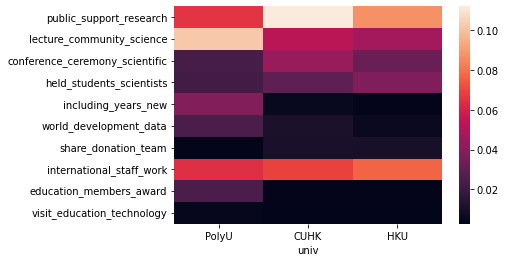

In [36]:
def seaborn_heatmap1(topicdata):
    myplot = sns.heatmap(data=topicdata.T) # transponiert = besser lesbar
    fig = myplot.get_figure()
    fig.savefig("topicdata-1.png", dpi=600)
   
seaborn_heatmap1(topicdata)    

### Etwas verfeinerte Darstellung

1. Mit den Zahlenwerten
2. Mit einer anderen Farbskala, siehe: https://matplotlib.org/stable/tutorials/colors/colormaps.html
3. Mit Linien
4. Mit einem Titel

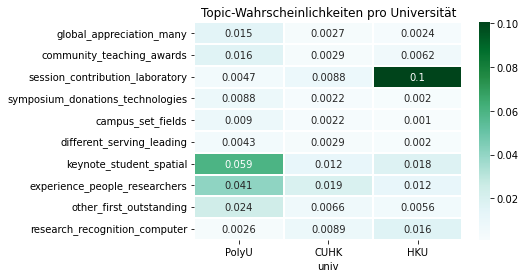

In [51]:
def seaborn_heatmap2(topicdata):
    myplot = sns.heatmap(data = topicdata.T,    # Daten transponiert
                         cmap = "BuGn",         # BuGn, PuRd, YlGnBu
                         annot = True,          # Annotiert: mit Werten
                         linewidths = 2,        # Linienstärke
                         linecolor = "white",   # Linienfarbe
                         cbar = True,           # Ob die Skala angezeigt wird
                         square = False         # Ob die Felder quadratisch sein sollen
                        ).set_title("Topic-Wahrscheinlichkeiten pro Universität")
    fig = myplot.get_figure()
    fig.savefig("topicdata-2.png", dpi=300)
   
seaborn_heatmap2(topicdata)    

## Bonus: Clustermap 

Als kleiner Bonus bietet seaborn auch eine sehr schöne Variante der Heatmap an, die aber nur in spezifischen Fällen nützlich ist: die Clustermap. Hier wird ein Clustering durchgeführt und die Heatmap so reorganisiert, dass Datenpunkte mit ähnlichen Eigenschaften als Gruppen sichtbar werden. 

Nur zur Demonstration hiervon noch eine solche Clustermap, die in diesem Falle auf authentischen Daten zur Korrelation von unterschiedlichen Distinktivitätsmaßen beruht. 

![Clustermap](../E31_seaborn/clustermap.png)

## Fazit

Beide Bibliotheken habe ihre Vor- und Nachteile. Entscheiden Sie selbst, wann Sie welche einsetzen möchten. 

Oft hat man mehr Daten generiert und in einer Tabelle zusammengeführt, als sich sinnvoll visualisieren lassen. Wichtig ist, die Aufbereitung der Daten von der eigentlichen Visualisierung zu trennen. 